# Sec Recon Network

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import combinations
from utils import get_gene_color, flatten_processes

In [2]:
# Generate secrecon dataframe
secrecon = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="master_curated_09202021")
unprocesses = pd.read_excel("Input/uniqueProcesses_finalOntology.xlsx", sheet_name="Final ontology")
complexes = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="Complexes")

In [3]:
#Generate dictionaries

gene_dict = {}
for index, row in secrecon.iterrows():
    gene = row['GENE SYMBOL']
    # Grab the processes and filter out any NaN values
    processes = row[['Process 1', 'Process 2', 'Process 3', 'Process 4', 'Process 5',
                     'Process 6', 'Process 7', 'Process 8', 'Process 9', 'Process 10']].dropna().tolist()
    gene_dict[gene] = {'processes': processes}
    
# Process Dict
process_dict = {}

for index, row in unprocesses.iterrows():
    system = row['System']
    subsystem = row['Subsystem'] if pd.notna(row['Subsystem']) else None
    process = row['Process'] if pd.notna(row['Process']) else None
    subprocess = row['Subprocess'] if pd.notna(row['Subprocess']) else None
    
    if system not in process_dict:
        process_dict[system] = []
        
    process_dict[system].append({k: v for k, v in {
        'Subsystem': subsystem,
        'Process': process,
        'Subprocess': subprocess
    }.items() if v is not None})
    
#Complexes dict
complexes_dict = complexes.groupby('Complex')['Gene'].apply(list).to_dict()

In [4]:
# Add the complexes to the gene_dict. If a gene is not part of any complex, we will put 'Not part of any complex'
for gene in gene_dict:
    gene_dict[gene]['complex'] = complexes_dict.get(gene, 'Not part of any complex')

In [5]:
gene_dict

{'A3GALT2': {'processes': ['Isoglobo series'],
  'complex': 'Not part of any complex'},
 'A4GALT': {'processes': ['Globo series'],
  'complex': 'Not part of any complex'},
 'A4GNT': {'processes': ['O-glycan mucin'],
  'complex': 'Not part of any complex'},
 'ABL1': {'processes': ['Kinase',
   'Cytoskeletal remodeling',
   'Endocytosis',
   'Apoptosis',
   'ER stress response/UPR'],
  'complex': 'Not part of any complex'},
 'ABL2': {'processes': ['Kinase', 'Cytoskeletal remodeling', 'Endocytosis'],
  'complex': 'Not part of any complex'},
 'ABO': {'processes': ['Glycosylation'], 'complex': 'Not part of any complex'},
 'ACAP1': {'processes': ['Endocytic recycling', 'Clathrin'],
  'complex': 'Not part of any complex'},
 'ACAP2': {'processes': ['Endocytosis'], 'complex': 'Not part of any complex'},
 'ACAP3': {'processes': ['Endocytosis'], 'complex': 'Not part of any complex'},
 'ACTR2': {'processes': ['Cytoskeletal remodeling'],
  'complex': 'Not part of any complex'},
 'ACTR3': {'processe

In [6]:
# Colouring the nodes according the systems
category_colors = {
    'Translocation': 'blue',
    'Protein conformation': 'red',
    'Post-translational modifications': 'green',
    'Proteostasis': 'purple',
    'Vesicle trafficking': 'yellow'
}

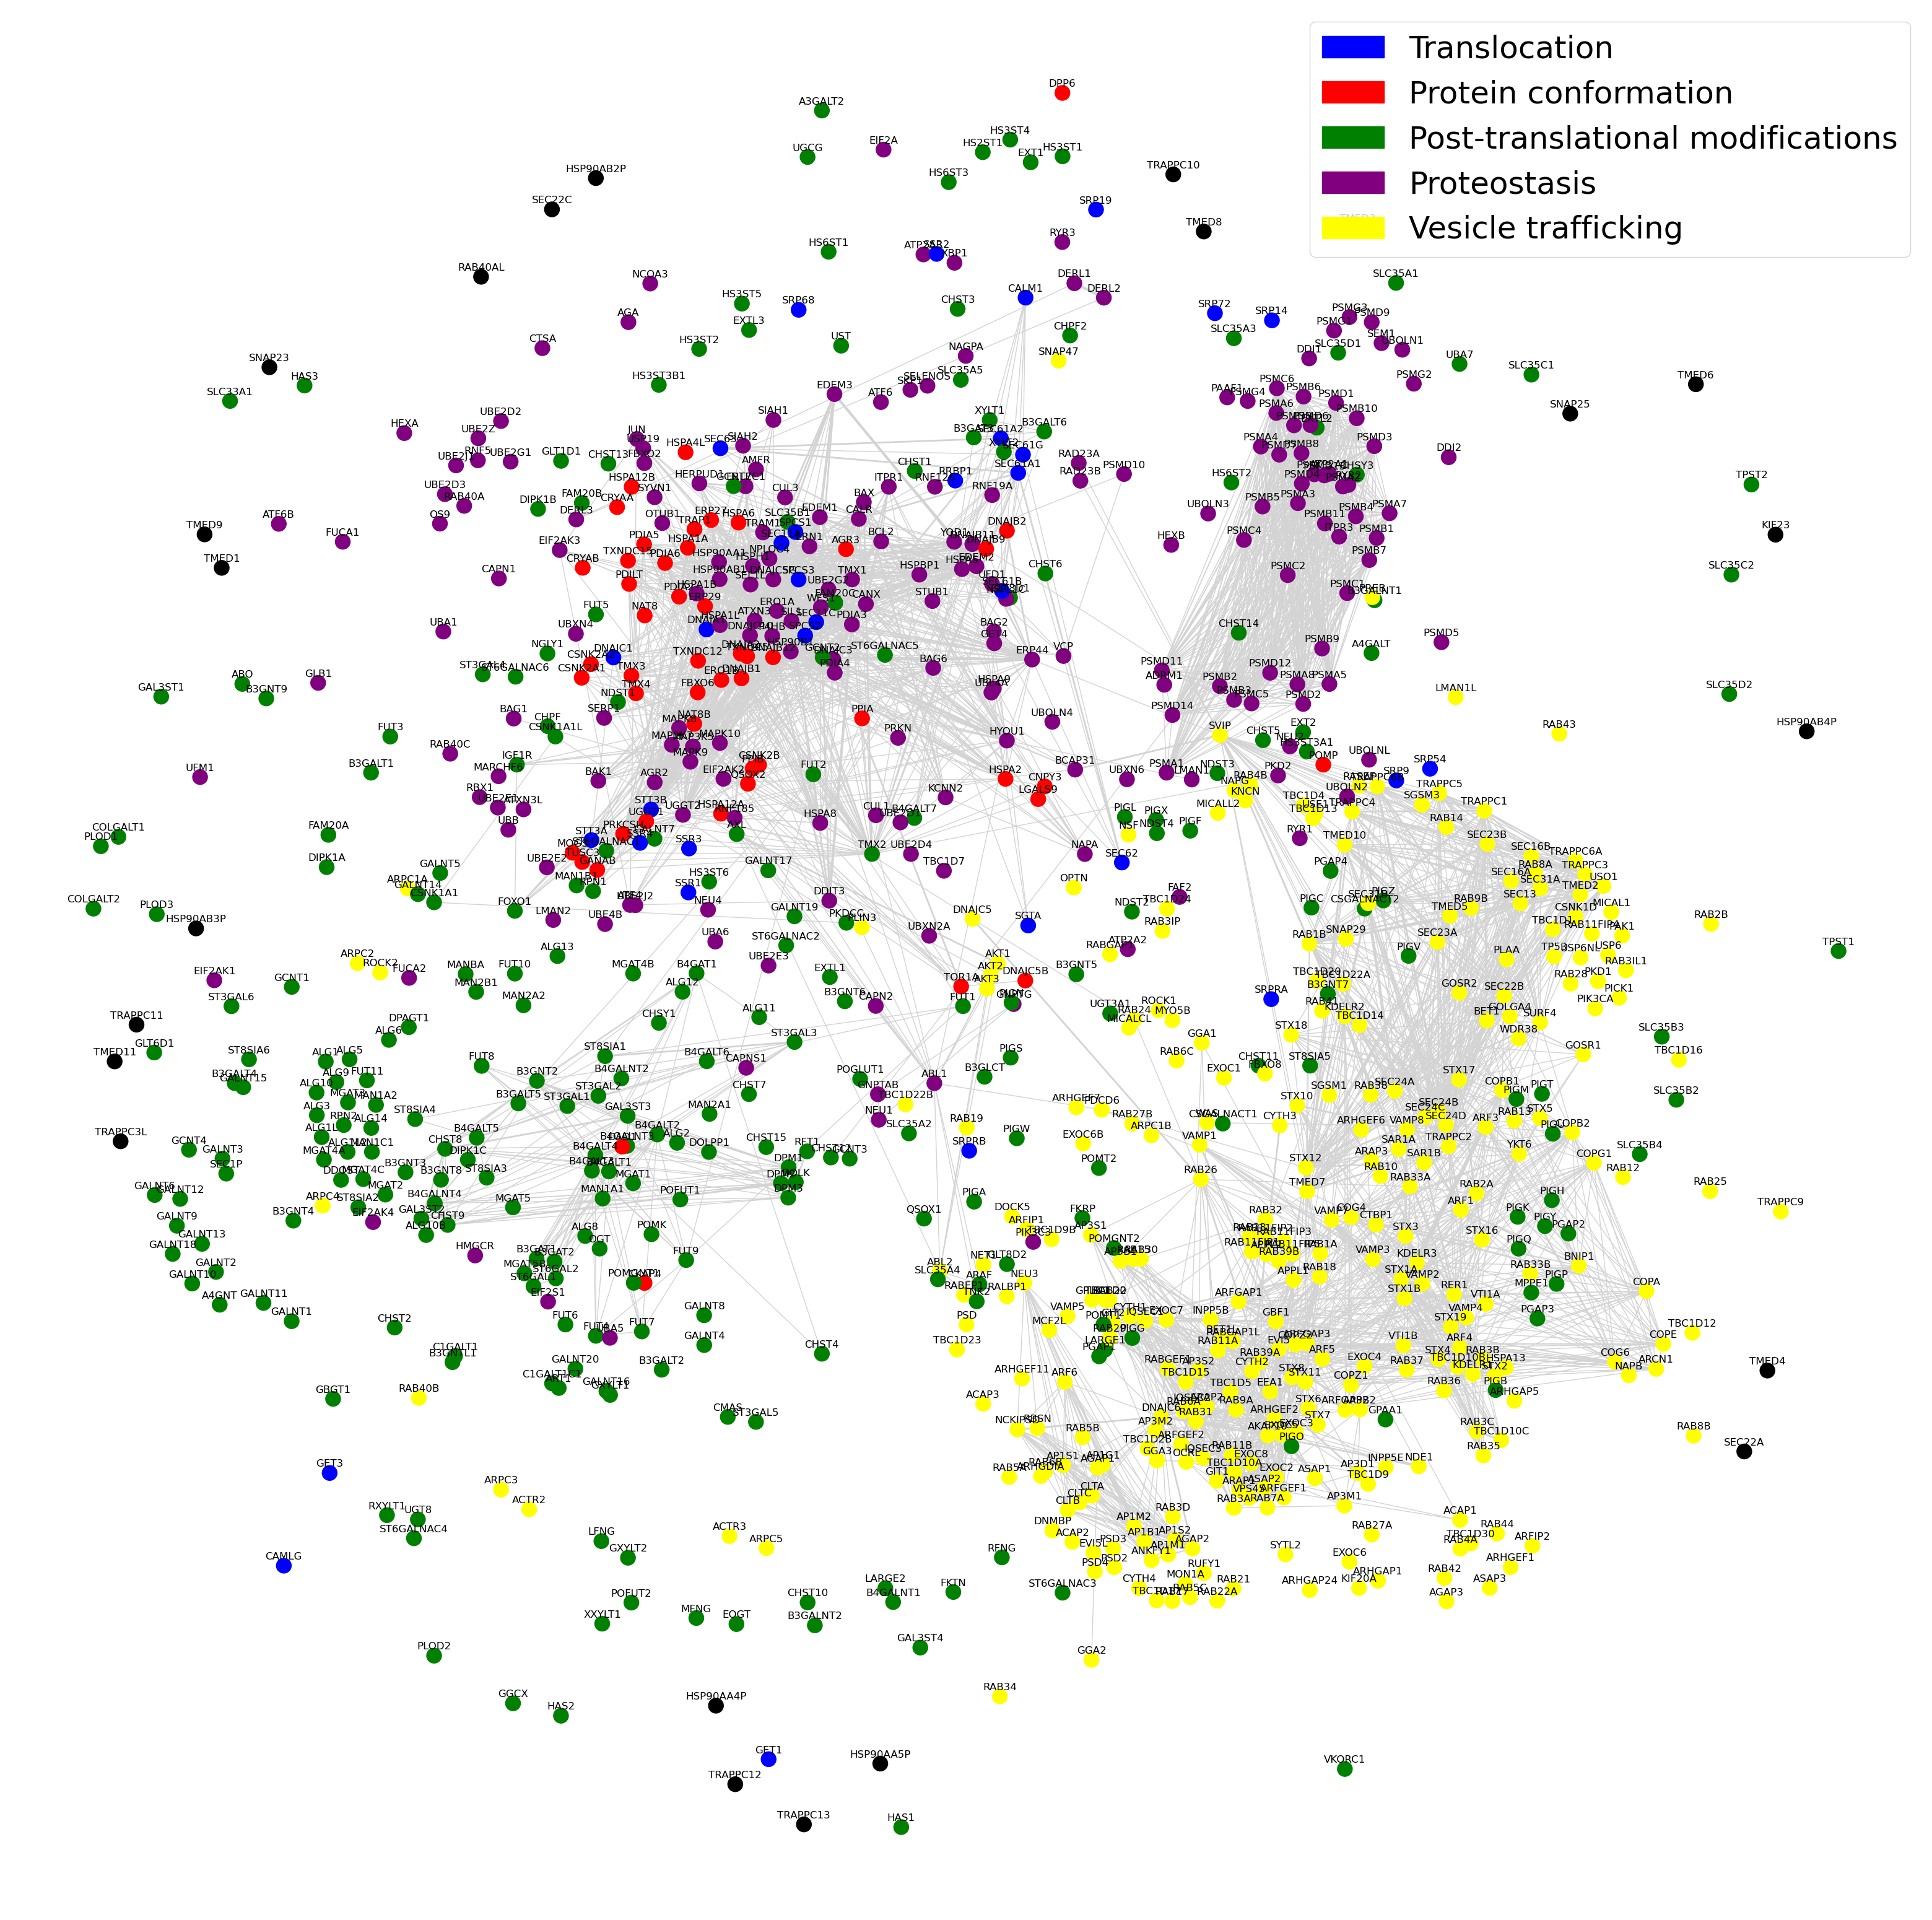

In [ ]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Color code node according to the System they belong to
node_colors = [get_gene_color(node, gene_dict, process_dict, category_colors) for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.6)   # Set fixed position for nodes
# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]

nx.draw(G, pos, node_color=node_colors, edgelist=edgelist, node_size=300, edge_color='lightgrey', 
        width=[G[u][v]['weight'] for u, v in G.edges()], ax=ax)  # Set edge width to be proportional to the shared processes

# labels
label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=12) 

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.show()